In [1]:
import os
os.chdir('../')

os.getcwd()

'f:\\GraphCPP'

In [2]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import pandas as pd

import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
sns.set_context("paper")

%matplotlib inline

c:\Users\imrea\mambaforge\envs\graphcpp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from graphcpp.dataset import CPPDataset

train = CPPDataset(root='2024-07-24-16-24-56/70', _split='train')
val = CPPDataset(root='2024-07-24-16-24-56/70', _split='val')
test = CPPDataset(root='2024-07-24-16-24-56/70', _split='test')
dataset = list()
for data in train: dataset.append(data)
for data in val: dataset.append(data)
for data in test: dataset.append(data)
labels = [data.y.numpy()[0] for data in dataset]

dataloader = DataLoader(dataset, batch_size=1)


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [4]:
dataset

[Data(x=[91, 32], edge_index=[2, 182], edge_attr=[182, 11], name='MLCPP2_non_CPP_4095', y=[1], fp=[1, 2048], smiles='CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H](N)CC(N)=O)C(C)C)[C@@H](C)O)C(=O)O'),
 Data(x=[137, 32], edge_index=[2, 272], edge_attr=[272, 11], name='Dobchevetal_CPP_3291', y=[1], fp=[1, 2048], smiles='CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)O)[C@@H](C)O)[C@@H](C)O)[C@@H](C)O'),
 Data(x=[146, 32], edge_index=[2, 304], edge_attr=[304, 11], name='C2Pred_CPP_145', y=[1], fp=[1, 2048], smiles='CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CS

# Embedding without training

(1708, 2)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


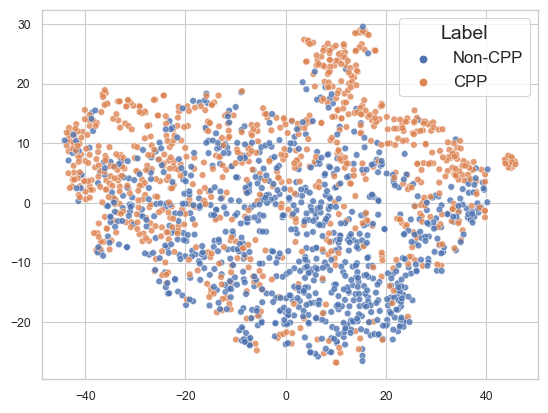

In [13]:
# 1. Pooling or aggregating node features
def mean_pooling(graph):
    return torch.mean(graph.x, dim=0)
def add_pooling(graph):
    return torch.add(graph.x, dim=0)

# Global Attention Pooling
class GraphGlobalAttention(nn.Module):
    def __init__(self, node_feature_dim, attention_dim):
        super(GraphGlobalAttention, self).__init__()
        self.attention = gnn.aggr.AttentionalAggregation(gate_nn=nn.Linear(node_feature_dim, 1), nn=nn.Linear(node_feature_dim, attention_dim))

    def forward(self, x):
        # Graph should be a torch_geometric.data.Data object
        return self.attention(x)

global_attention_model = GraphGlobalAttention(node_feature_dim=32, attention_dim=256)

graph_representations = []

for graph in dataset:
    pooled_features = mean_pooling(graph)
    # pooled_features = global_attention_model(graph.x).squeeze(0)
    graph_representations.append(pooled_features)

# 2. Stack the graph representations
graph_representations = torch.stack(graph_representations)

# 3. Apply t-SNE
tsne = TSNE(n_components=2,
    perplexity=50,
    init="pca",
    # n_iter=10000,
    random_state=42)
embedded_graphs = tsne.fit_transform(graph_representations.detach().numpy())

print(embedded_graphs.shape)

# Create a DataFrame for plotting
embedded_graphs_df = pd.DataFrame(embedded_graphs, columns=['x', 'y'])
# set label to non-CPP if 0 and CPP if 1
embedded_graphs_df['label'] = ['CPP' if label == 1 else 'Non-CPP' for label in labels]

# Visualize the t-SNE results
sns.scatterplot(data=embedded_graphs_df, x='x', y='y', hue='label', alpha=0.8, palette=['#4c72b0', '#dd8452'])
# disable x and y axis labels set labels to emptry string
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Label', fontsize=12, title_fontsize=14)
plt.savefig('assets/before_tsne.eps', dpi=300, bbox_inches='tight')
plt.savefig('assets/before_tsne.png', dpi=300, bbox_inches='tight')

# Embedding after training

In [9]:
from rdkit import Chem
from graphcpp.fp_generators import fp_dict
from graphcpp.lightning import GraphCPPModule

# Before applying t-SNE, we should change the import in the lightning.py file.
model = GraphCPPModule.load_from_checkpoint(checkpoint_path="model/checkpoints/epoch=22-step=69.ckpt").model
model.eval()

embeddings = list()
with torch.no_grad():
    for data in dataloader:
        # Load fingerprint
        mol = Chem.MolFromSmiles(data.smiles[0])
        fp = fp_dict['topological'].GetFingerprint(mol)
        data.fp = torch.tensor([fp], dtype=torch.float32)

        pred, label, embedding = model(data)
        embeddings.append(embedding.squeeze(0).numpy())

Sequential(
  (0): Linear(
    (model): Linear(in_features=2048, out_features=128, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=256, out_features=1, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=2048, out_features=128, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=256, out_features=1, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=2048, out_features=128, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=256, out_features=1, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=2048, out_features=128, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=256, out_features=1, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=2048, out_features=128, bias=True)
  )
)
Sequential(
  (0): Linear(
    (model): Linear(in_features=256, out_features=1, bias=True)
  )
)
Sequential(
  (

In [7]:
embeddings

[array([-4.36194241e-02, -1.62962880e-02,  7.43705854e-02, -3.23905721e-02,
        -2.73370948e-02, -1.37088532e-02, -1.24477362e-02, -2.34463997e-02,
         2.26438612e-01, -2.48428881e-02, -8.97438079e-03,  6.93221018e-02,
         1.17483949e-02,  7.86355790e-03,  1.92198679e-01, -7.04769557e-03,
        -2.47832313e-02, -2.89839841e-02,  8.29243064e-02, -6.64046183e-02,
         2.05914471e-02,  7.37557188e-02, -5.86208291e-02, -3.18818465e-02,
        -6.08084947e-02, -3.47987749e-02, -5.85436597e-02,  6.09534644e-02,
         5.05540706e-02, -5.64404912e-02, -5.06781414e-02,  2.35774517e-01,
        -1.85850188e-02,  4.79052454e-01,  3.16253036e-01,  1.38709933e-01,
        -5.94777018e-02,  3.19532931e-01, -3.31649669e-02,  1.12731323e-01,
        -8.76333751e-03, -2.54519098e-02, -2.19108835e-02,  1.89182699e-01,
         3.24739441e-02, -2.23852061e-02, -5.26919728e-03,  3.19682062e-02,
         2.19843358e-01,  1.04177110e-01,  2.64435977e-01, -6.41971678e-02,
        -5.8

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


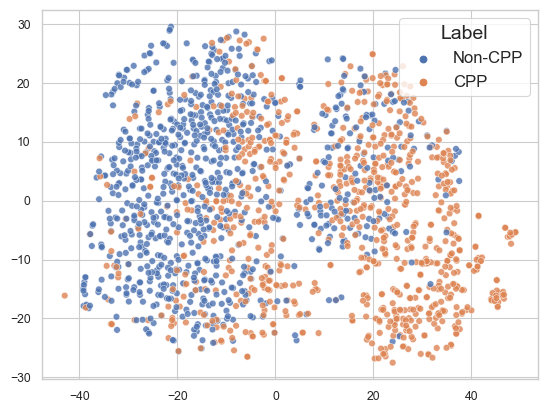

In [12]:
# final_embedding = model_value[2].squeeze(0).numpy()
X = np.array(embeddings)

tsne = TSNE(n_components=2,
    perplexity=50,
    init="pca",
    # n_iter=10000,
    random_state=42)
embedded_graphs = tsne.fit_transform(X)

# Create a DataFrame for plotting
embedded_graphs_df = pd.DataFrame(embedded_graphs, columns=['x', 'y'])
# set label to non-CPP if 0 and CPP if 1
embedded_graphs_df['label'] = ['CPP' if label == 1 else 'Non-CPP' for label in labels]

# Visualize the t-SNE results
sns.scatterplot(data=embedded_graphs_df, x='x', y='y', hue='label', alpha=0.8, palette=['#4c72b0', '#dd8452'])
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Label', fontsize=12, title_fontsize=14)
# plt.show()
# sns.scatterplot(x=embedded_graphs[:, 0], y=embedded_graphs[:, 1], hue=labels, alpha=0.8, palette=['#4c72b0', '#dd8452'], data=embedded_graphs)#.set(title="t-SNE projection of the entire dataset after training") 
plt.savefig('assets/after_tsne.eps', dpi=300, bbox_inches='tight')
plt.savefig('assets/after_tsne.png', dpi=300, bbox_inches='tight')